In [1]:
!pip install gymnasium
!pip install gymnasium[classic-control]

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [10]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F
import os
import datetime

import import_ipynb
from TrulyPlastic_allOpt import plastic_nn
from TrulyPlastic_allOpt import input_layer
from TrulyPlastic_allOpt import layer

In [3]:
# np.random.seed(4)

In [11]:

# Define memory for Experience Replay
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)




class DQN():
    # Hyperparameters (adjustable)
    def __init__(s, path = r'test', game_name = 'MountainCar-v0', discount_factor_g = 0.9, mini_batch_size = 64, 
                  num_divisions = 50, replay_memory_size = 100000, network_sync_rate = 50000):

        s.path = path
        current_directory = os.getcwd()
        final_directory = os.path.join(current_directory, s.path)
        if not os.path.exists(final_directory):
            os.makedirs(final_directory)
    
        s.game_name = game_name
        s.discount_factor_g = discount_factor_g
         
        s.mini_batch_size = mini_batch_size 
        s.num_divisions = num_divisions

        s.replay_memory_size =  replay_memory_size 
        s.network_sync_rate = network_sync_rate
        
    
    def plot_progress(self, rewards_per_episode, epsilon_history):
        
        plt.figure(1)
        plt.subplot(121) 
        plt.xlabel('epochs')
        plt.ylabel('reward')
        plt.plot(rewards_per_episode)
        plt.subplot(122) # plot on a 1 row x 2 col grid, at cell 2
        plt.xlabel('epochs')
        plt.ylabel('epsilon')
        plt.plot(epsilon_history)
        plt.savefig(f'{self.path}/info.png'.format(self.path))

    

    def train(self, policy_dqn, target_dqn, episodes, render=False):
        # Create FrozenLake instance
        env = gym.make(self.game_name, render_mode='human' if render else None)
        num_states = env.observation_space.shape[0] # expecting 2: position & velocity
        num_actions = env.action_space.n

        # Divide position and velocity into segments
        self.pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)    # Between -1.2 and 0.6
        self.vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)    # Between -0.07 and 0.07

        epsilon = 1 # 1 = 100% random actions
        memory = ReplayMemory(self.replay_memory_size)

        rewards_per_episode = []
        epsilon_history = []

        # Track number of steps taken. Used for syncing policy => target network.
        step_count = 0
        goal_reached = False
        best_rewards = -200

        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False
            rewards = 0

            while(not terminated and rewards > -1000):
                if random.random() < epsilon:
                    action = env.action_space.sample() # actions: 0=left,1=idle,2=right
                else:
                    res = policy_dqn.forward(self.state_to_dqn_input(state))
                    action = res.argmax().item()

                new_state,reward,terminated,truncated,_ = env.step(action)
                rewards += reward
                memory.append((state, action, new_state, reward, terminated))
                state = new_state
                step_count+=1


            rewards_per_episode.append(rewards)
            
            if(terminated):
                goal_reached = True

            # Graph training progress
            if(i!=0 and i%1000==0):
                print(f'Episode {i} Epsilon {epsilon}')
                policy_dqn.save(f'{self.path}/mc_policy_{i}'.format(self.path, i))
                self.plot_progress(rewards_per_episode, epsilon_history)

            if rewards>best_rewards:
                best_rewards = rewards
                print(f'Best rewards so far: {best_rewards}')
                policy_dqn.save(f'{self.path}/mc_policy_{i}'.format(self.path, i))
                

            # Check if enough experience has been collected
            if len(memory)>self.mini_batch_size and goal_reached:
                
                #print(f'OPTIMIZE Episode {i} Epsilon {epsilon} rewards {rewards}') # print(rewards)
                
                mini_batch = memory.sample(self.mini_batch_size)
                self.optimize(mini_batch, policy_dqn, target_dqn)

                # Decay epsilon
                epsilon = epsilon = max(epsilon - 1/episodes, 0.01) # max(epsilon*0.99996, 0.05)#
                epsilon_history.append(epsilon)

                # Copy policy network to target network after a certain number of steps
                if step_count > self.network_sync_rate:
                    target_dqn = policy_dqn.deep_copy()
                    step_count = 0
                   
                
                
        env.close()



    
    def optimize(self, mini_batch, policy_dqn, target_dqn):
        target_q_list = []
        input_list = []
        
        for state, action, new_state, reward, terminated in mini_batch:
            if terminated:
                target = reward
            else:
                target = reward + self.discount_factor_g * target_dqn.forward(self.state_to_dqn_input(new_state)).max()

            # Get the target set of Q values
            state_dsc = np.asarray(self.state_to_dqn_input(state))
            input_list.append(state_dsc)
            
            target_q = target_dqn.forward(state_dsc)
            
            # Adjust the specific action to the target that was just calculated
            target_q[action] = target            
            target_q_list.append(target_q)

        #BACKPOP AND UPDATE on minibatch
        x = np.asarray(input_list)
        x = x[:, :, 0]
        x = x.T

        y = np.asarray(target_q_list)
        y = y[:, :, 0]
        y = y.T

        policy_dqn.learn_one(x, y)



    def state_to_dqn_input(self, state):
        state_p = np.digitize(state[0], self.pos_space)
        state_v = np.digitize(state[1], self.vel_space)

        return np.asarray([[state_p], [state_v]])

        

    def test(self, policy_dqn, episodes, render = False):
        env = gym.make(self.game_name, render_mode='human' if render else None)
        
        num_states = env.observation_space.shape[0]
        num_actions = env.action_space.n

        self.pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)    # Between -1.2 and 0.6
        self.vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)    # Between -0.07 and 0.07

        done_count = 0
        
        for i in range(episodes):
            state, info = env.reset()  # Initialize to state 0
            done = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while(not done and not truncated):
                state = self.state_to_dqn_input(state)
                #print('state shape', state.shape)
               
                res = policy_dqn.forward(state)

                action = res.argmax().item()
                #print(res)
                state, reward, done, truncated, _ = env.step(action)
                if (done):
                    done_count += 1

        print(done_count/episodes)
        env.close()

    def save_info(s):
        file_path = f'{s.path}/info.txt'.format(s.path)
        f = open(file_path, "a")   
       

        ct = datetime.datetime.now()

        f.write("{}\n".format(ct))
        
        f.write("{}\n".format(s.game_name))
        f.write("{}\n".format(s.discount_factor_g))
        f.write("{}\n".format(s.mini_batch_size))
        f.write("{}\n".format(s.num_divisions))
        f.write("{}\n".format(s.replay_memory_size))
        f.write("{}\n".format(s.network_sync_rate))
                         
        f.close()


In [12]:
learning_rate_a = 0.01
in_states = 2
h1_nodes = 20
h2_nodes = 20
out_actions = 3

layers_net = [input_layer(in_states), 
layer(lr = learning_rate_a, prev_size = in_states, my_size=h1_nodes, activation_type="ReLU"), 
#layer(lr = learning_rate_a, prev_size = h1_nodes, my_size=h2_nodes, activation_type="ReLU"), 
layer(lr = learning_rate_a, prev_size = h2_nodes, my_size=out_actions, activation_type='Linear')]

policy_dqn = plastic_nn(optimizer="Adam")
policy_dqn.append_layers(layers_net)

target_dqn = plastic_nn()
target_dqn = policy_dqn.deep_copy()


added LAYERS succesfully


In [13]:
mountaincar = DQN(path = r'test3', game_name = 'MountainCar-v0', discount_factor_g = 0.9, mini_batch_size = 32, 
                  num_divisions = 50, replay_memory_size = 100000, network_sync_rate = 50000)


Episode 1000 Epsilon 0.990750000000001
Episode 2000 Epsilon 0.9407500000000065
Episode 3000 Epsilon 0.890750000000012
Episode 4000 Epsilon 0.8407500000000175
Episode 5000 Epsilon 0.790750000000023
Episode 6000 Epsilon 0.7407500000000286
Episode 7000 Epsilon 0.6907500000000341
Episode 8000 Epsilon 0.6407500000000396
Episode 9000 Epsilon 0.5907500000000451
Episode 10000 Epsilon 0.5407500000000506
Episode 11000 Epsilon 0.4907500000000561
Episode 12000 Epsilon 0.4407500000000616
Episode 13000 Epsilon 0.3907500000000671
Episode 14000 Epsilon 0.3407500000000726
Episode 15000 Epsilon 0.2907500000000781
Episode 16000 Epsilon 0.24075000000008362
Episode 17000 Epsilon 0.19075000000008913
Episode 18000 Epsilon 0.14075000000009463
Episode 19000 Epsilon 0.09075000000010014


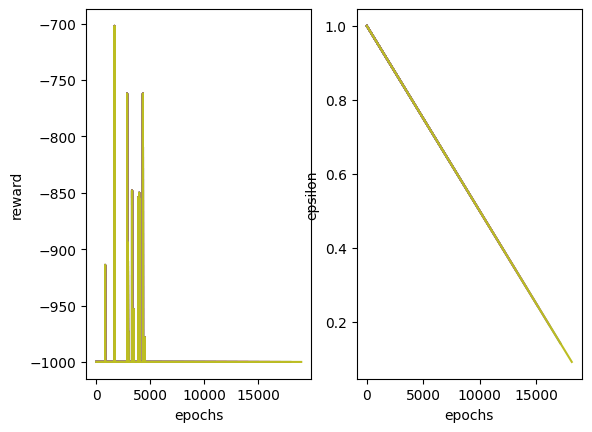

In [14]:
mountaincar.train(policy_dqn, target_dqn, 20000, False)
mountaincar.save_info()

In [17]:
policy_dqn.load('01_06x2/2024-06-01_19-01-18/04_04_00/mc_policy_4785')

added LAYERS succesfully


In [22]:
mountaincar.test(policy_dqn, 10000, render = False)

1.0


In [19]:
policy_dqn.print_info()

NAME:  noname  ( 4 )
# 0
IN LAYER
size:  2

# 1
my size:  4
prev size:  2
w:  [[0.12710583 0.32434641]
 [0.77047438 0.21157584]
 [0.55380778 0.60785312]
 [0.48676748 0.19940017]] 

b:  [[0.12710583 0.32434641]
 [0.77047438 0.21157584]
 [0.55380778 0.60785312]
 [0.48676748 0.19940017]] 


# 2
my size:  4
prev size:  4
w:  [[ 0.64404818  0.3108764   0.60222571  0.63754014]
 [-0.11982383  0.43479872  0.28890089  0.5886289 ]
 [ 0.45664703  0.45511194  0.55699367  0.27690069]
 [ 0.43681268  0.37641901  0.14484144  0.08224771]] 

b:  [[ 0.64404818  0.3108764   0.60222571  0.63754014]
 [-0.11982383  0.43479872  0.28890089  0.5886289 ]
 [ 0.45664703  0.45511194  0.55699367  0.27690069]
 [ 0.43681268  0.37641901  0.14484144  0.08224771]] 


# 3
my size:  3
prev size:  4
w:  [[ 0.13127907  0.63532761  0.34372447  0.83240441]
 [-0.05984588  0.70498019  0.62814778  0.6323994 ]
 [ 0.65514943  0.31617783  0.15903304  0.46173394]] 

b:  [[ 0.13127907  0.63532761  0.34372447  0.83240441]
 [-0.05984588

In [11]:
policy_dqn.print_info()

NAME:  noname  ( 3 )
# 0
IN LAYER
size:  2

# 1
my size:  20
prev size:  2
w:  [[-1.42604271e-01  4.91774026e-02]
 [-1.61737089e-01  8.13014781e-02]
 [ 5.51689625e-02 -1.27806614e-01]
 [-2.43820291e-01 -7.67588049e-03]
 [-1.80868559e-01 -1.68990953e-02]
 [-4.79651602e-01  2.73962033e-03]
 [-2.73314739e-01  4.87380746e-03]
 [-7.20152137e-02 -1.01200538e-03]
 [-5.08010389e-02  2.71859557e-01]
 [-3.27941014e-01  1.40511318e-01]
 [-1.68927808e-01 -2.77216663e-04]
 [-2.24713575e-02 -4.16400257e-02]
 [-4.87328315e-01  1.33803602e-03]
 [ 3.47378858e-01 -1.97111084e-01]
 [-4.44474307e-01  2.92638880e-01]
 [-1.66589482e-01  4.61197450e-03]
 [ 9.44240458e-02  2.22236472e-01]
 [ 8.85187056e-02 -5.45793759e-02]
 [-3.81550545e-02  7.02427093e-02]
 [-3.17373484e-03  6.50914932e-04]] 

b:  [[-1.42604271e-01  4.91774026e-02]
 [-1.61737089e-01  8.13014781e-02]
 [ 5.51689625e-02 -1.27806614e-01]
 [-2.43820291e-01 -7.67588049e-03]
 [-1.80868559e-01 -1.68990953e-02]
 [-4.79651602e-01  2.73962033e-03]
 [-2

In [12]:
# a = [[10, 11], [6, 6], [9, 14], [7, 10], [8, 12], [7, 10], [7, 9], [9, 10], [8, 9], [8, 9], [9, 12], [7, 8], [5, 10], [7, 10], [10, 12], [9, 12], [7, 9], [8, 11], [7, 9], [11, 9], [7, 7], [10, 9], [8, 11], [10, 11], [7, 13], [9, 10], [8, 9], [8, 9], [8, 10], [8, 10], [9, 11], [6, 16]]